#Anchor Box Calculation



k,dim = 9 3
iter 1: dists = 2008.8511362947934
iter 2: dists = 148.06174692543664
iter 3: dists = 126.85651053757705
iter 4: dists = 52.696428972132054
iter 5: dists = 73.18639120720397
iter 6: dists = 34.29783300882434
iter 7: dists = 18.73626612605078
iter 8: dists = 21.718356518589218
iter 9: dists = 25.323835754230295
iter 10: dists = 27.426342100837054
iter 11: dists = 17.162267348407312
iter 12: dists = 11.091516384992842
iter 13: dists = 5.215621621679143
iter 14: dists = 11.138090208285835
iter 15: dists = 10.20486098591151
iter 16: dists = 5.121823042387248
iter 17: dists = 1.965023341247727
iter 18: dists = 1.2500247812116378
iter 19: dists = 5.41486612437906
iter 20: dists = 3.5481020177110727
iter 21: dists = 3.182340860223835
iter 22: dists = 0.8699741538837484
Centroids =  [[0.01904226 0.05000714 0.57981667]
 [0.01292338 0.03109058 0.31196364]
 [0.00437949 0.00429515 0.33207692]
 [0.01426509 0.03369488 0.33257358]
 [0.03385    0.00955714 0.2802    ]
 [0.00541857 0.0070229

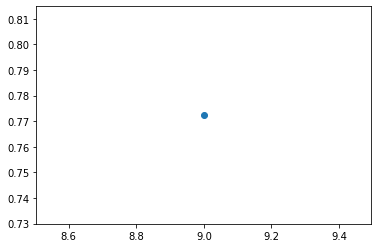

In [ ]:
import matplotlib.pyplot as plt

class main:
  def __init__(self,no):
    self.num_clusters = no

   
args = main(9)

'''
Created on Feb 20, 2017
@author: jumabek
'''
from os import listdir
from os.path import isfile, join
import argparse
#import cv2
import numpy as np
import sys
import os
import shutil
import random 
import math

width_in_cfg_file = 1248.
height_in_cfg_file = 1248.

def IOU(X,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_x,c_y,c_z = centroid
        x,y,z = X
        inner_vol = min(x,c_x)*min(y,c_y)*min(z,c_z)
        similarity = inner_vol/((x*y*z+c_x*c_y*c_z)-inner_vol)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    for i in range(anchors.shape[0]):
        anchors[i][0]*=width_in_cfg_file
        anchors[i][1]*=height_in_cfg_file
        anchors[i][2]*= 5
         

    widths = anchors[:,0]+ anchors[:,1]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.5f,%0.5f,%0.5f, '%(anchors[i,0],anchors[i,1],anchors[i,2]))

    #there should not be comma after last anchor, that's why
    f.write('%0.5f,%0.5f,%0.5f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1],anchors[sorted_indices[-1:],2]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))
    plt.scatter(centroids.shape[0], avg_IOU(X,centroids))

def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    print("k,dim =",k,dim)
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)
            write_anchors_to_file(centroids,X,anchor_file)
            return

        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  

    

annotation_dims = []

size = np.zeros((1,1,3))
file_path = '/gdrive/My Drive/data/'
for scene  in nusc.scene :
  sample_token = scene['first_sample_token']
  sample = nusc.get('sample',sample_token)
  sensor = 'LIDAR_TOP'
  lidar_top_data = nusc.get('sample_data', sample['data'][sensor])
  ego_pose = nusc.get('ego_pose', lidar_top_data['ego_pose_token'])
  for annotation in sample['anns']:
    annotation = nusc.get('sample_annotation',annotation)
    x,y,z = annotation['size']
    x = float(x) / 140.
    y = float(y) / 140.
    z = float(z) / 5.
    annotation_dims.append(tuple(map(float,(x,y,z))))
#print(annotation_dims)  
annotation_dims = np.array(annotation_dims)

eps = 0.005

if args.num_clusters == 0:
    for num_clusters in range(1,11): #we make 1 through 10 clusters 
        anchor_file = 'anchors%d.txt'%(num_clusters)

        indices = [ random.randrange(annotation_dims.shape[0]) for i in range(num_clusters)]
        centroids = annotation_dims[indices]
        kmeans(annotation_dims,centroids,eps,anchor_file)
        print('centroids.shape', centroids.shape)
else:
    anchor_file = 'anchors%d.txt'%(args.num_clusters)
    indices = [ random.randrange(annotation_dims.shape[0]) for i in range(args.num_clusters)]
    centroids = annotation_dims[indices]
    kmeans(annotation_dims,centroids,eps,anchor_file)
    print('centroids.shape', centroids.shape)



In [ ]:
from collections import Counter 

annotation_dims = []
cat = []
size = np.zeros((1,1,3))
file_path = '/gdrive/My Drive/data/'
for scene  in nusc.scene :
  sample_token = scene['first_sample_token']
  sample = nusc.get('sample',sample_token)
  sensor = 'LIDAR_TOP'
  lidar_top_data = nusc.get('sample_data', sample['data'][sensor])
  ego_pose = nusc.get('ego_pose', lidar_top_data['ego_pose_token'])
  for annotation in sample['anns']:
    annotation = nusc.get('sample_annotation',annotation)
    print(annotation['size'],annotation['category_name'])
    x,y,z = annotation['size']
    cat.append(annotation['category_name'])
    #x = float(x) / 140.
    #y = float(y) / 140.
    #z = float(z) / 5.
    annotation_dims.append(tuple(map(float,(x,y,z))))
print(annotation_dims)
d = Counter(cat)   
print(d)
print(annotation_dims[1])
print(max(x[0] for x in annotation_dims))
print(max(x[1] for x in annotation_dims))
print(max(x[2] for x in annotation_dims))
#print(sum(annotation_dims[:,1]))
#print(sum(annotation_dims[:,2]))

[0.621, 0.669, 1.642] human.pedestrian.adult
[0.775, 0.769, 1.711] human.pedestrian.adult
[2.011, 4.633, 1.573] vehicle.car
[0.752, 0.819, 1.637] human.pedestrian.adult
[0.427, 0.359, 0.794] movable_object.trafficcone
[0.689, 1.77, 1.709] vehicle.bicycle
[0.661, 0.703, 1.839] human.pedestrian.adult
[1.837, 4.32, 1.631] vehicle.car
[0.648, 0.709, 1.609] human.pedestrian.adult
[1.977, 0.703, 1.149] movable_object.barrier
[1.91, 0.555, 1.055] movable_object.barrier
[1.019, 0.915, 1.67] human.pedestrian.adult
[0.934, 0.891, 1.835] human.pedestrian.adult
[0.8, 0.908, 1.835] human.pedestrian.adult
[0.872, 0.903, 1.719] human.pedestrian.adult
[1.964, 0.694, 1.131] movable_object.barrier
[1.708, 4.01, 1.631] vehicle.car
[0.79, 0.741, 1.725] human.pedestrian.adult
[2.877, 10.201, 3.595] vehicle.truck
[2.135, 4.956, 2.17] vehicle.car
[0.767, 0.951, 1.835] human.pedestrian.adult
[1.967, 0.704, 0.962] movable_object.barrier
[2.06, 0.759, 1.1] movable_object.barrier
[1.993, 0.744, 1.245] movable_ob

In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes 

nusc = NuScenes(version='v1.0-trainval', dataroot='data', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 36.819 seconds.
Reverse indexing ...
Done reverse indexing in 9.3 seconds.


#Start off

In [1]:
!pip3 install terminaltables
!pip install nuscenes-devkit
!pip install turfpy
!pip install wandb

  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=0c65552980a5256b232c88fab4f4b9cc9fc1def14fd46d288db0b43d78cc7373
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
     |████████████████████████████████| 266kB 8.1MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 143kB 8.6MB/s 
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111006 sha256=02a89500f96df9bfe6890fe1838a65c2193f2ea293469d6be8a3b7a7a95a8617
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
Successfully built fire
  Created wheel for turfpy: filename=turfpy-0.0.5-cp36-none-any.whl size=35769 sha256=f288ea187b05a233d1b68cee6affafeade1a841b5b5c4b895eacb53afb4de667
  Stored in directory: /root/.cache/pip/wheels/30/bc/f1/08b44fd3724a9c07109aba1dcae130ec547d4e1

In [2]:
#import wandb
#wandb.init()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

from __future__ import division

from terminaltables import AsciiTable

import os
import sys
import time
import datetime
import argparse

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim

#Utils

In [5]:
#Angle Decoder

def angle_decoder(r):
  teta1 = torch.asin(2*r[0] - 1)
  teta2 = torch.acos(2*r[1] - 1)
  teta = 0
  if 2*r[0] - 1 >= 0 and 2*r[1] - 1 >= 0:
    teta = (teta1+teta2)/2
  elif 2*r[0] - 1 >= 0 and 2*r[1] - 1 < 0:
    teta = (math.pi-teta1+teta2)/2
  elif 2*r[0] - 1 < 0 and 2*r[1] - 1 <= 0:
    teta = (math.pi - teta1+2*math.pi -teta2)/2
  elif 2*r[0] - 1 < 0 and 2*r[1] - 1 > 0:
    teta = (2*math.pi + teta1+2*math.pi - teta2)/2
  #print(teta)
  return teta

In [6]:
#Utils

from __future__ import division
import math
import time
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from turfpy.transformation import intersect
from turfpy.measurement import area
from geojson import Feature


def to_cpu(tensor):
    return tensor.detach().cpu()

def rotate_around_point(point, radians, origin=(0, 0)):
  """Rotate a point around a given point.
  
  I call this the "low performance" version since it's recalculating
  the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
  It's more readable than the next function, though.
  """
  x, y = point
  ox, oy = origin

  qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
  qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

  return qx, qy

def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, "r")
    names = fp.read().split("\n")[:-1]
    return names


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def rescale_boxes(boxes, current_dim, original_shape):
    """ Rescales bounding boxes to the original shape """
    orig_h, orig_w = original_shape
    # The amount of padding that was added
    pad_x = max(orig_h - orig_w, 0) * (current_dim / max(original_shape))
    pad_y = max(orig_w - orig_h, 0) * (current_dim / max(original_shape))
    # Image height and width after padding is removed
    unpad_h = current_dim - pad_y
    unpad_w = current_dim - pad_x
    # Rescale bounding boxes to dimension of original image
    boxes[:, 0] = ((boxes[:, 0] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 1] = ((boxes[:, 1] - pad_y // 2) / unpad_h) * orig_h
    boxes[:, 2] = ((boxes[:, 2] - pad_x // 2) / unpad_w) * orig_w
    boxes[:, 3] = ((boxes[:, 3] - pad_y // 2) / unpad_h) * orig_h
    return boxes


def xywh2xyxy(x):
    y = x.new(x.shape)
    y[..., 0] = x[..., 0] - x[..., 3] / 2
    y[..., 1] = x[..., 1] - x[..., 4] / 2
    y[..., 2] = x[..., 2] - x[..., 5] / 2
    y[..., 3] = x[..., 0] + x[..., 3] / 2
    y[..., 4] = x[..., 1] + x[..., 4] / 2
    y[..., 5] = x[..., 2] + x[..., 5] / 2
    return y


def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = np.unique(target_cls)

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in tqdm.tqdm(unique_classes, desc="Computing AP"):
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = (1 - tp[i]).cumsum()
            tpc = (tp[i]).cumsum()

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = np.array(p), np.array(r), np.array(ap)
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes.astype("int32")


def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i]
        pred_boxes = output[:, :8]
        pred_scores = output[:, 8]
        pred_labels = output[:, -1]

        true_positives = np.zeros(pred_boxes.shape[0])

        annotations = targets[targets[:, 0] == sample_i][:, 1:]
        target_labels = annotations[:, 0] if len(annotations) else []
        if len(annotations):
            detected_boxes = []
            target_boxes = annotations[:, 1:]

            for pred_i, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):

                # If targets are found break
                if len(detected_boxes) == len(annotations):
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)
                if iou >= iou_threshold and box_index not in detected_boxes:
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]
        batch_metrics.append([true_positives, pred_scores, pred_labels])
    return batch_metrics


def bbox_wh_iou(wh1, wh2):
    #print("wh2,wh1 =",wh2,wh1)
    wh2 = wh2.t()
    w1, l1, h1 = wh1[0], wh1[1] ,wh1[2]
    w2, l2, h2 = wh2[0], wh2[1] ,wh1[2]
    inter_area = torch.min(w1, w2) * torch.min(l1, l2) * torch.min(h1, h2)
    union_area = (w1 * l1 * h1 + 1e-16) + (w2 * l2 * h2) - inter_area
    #print("iou scores = ", inter_area / union_area)
    return inter_area / union_area


def bbox_iou(boxes1, boxes2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    #print("box shapes", box1.shape)
    iou_scores = []
    for box1,box2 in zip(boxes1,boxes2):
      if not x1y1x2y2:
          # Transform from center and width to exact coordinates
          b1_x1, b1_x3 = box1[0] - box1[3] / 2, box1[0] + box1[3] / 2
          b1_y1, b1_y3 = box1[1] - box1[4] / 2, box1[1] + box1[4] / 2
          b1_z1, b1_z3 = box1[2] - box1[5] / 2, box1[2] + box1[5] / 2
          b2_x1, b2_x3 = box2[0] - box2[3] / 2, box2[0] + box2[3] / 2
          b2_y1, b2_y3 = box2[1] - box2[4] / 2, box2[1] + box2[4] / 2
          b2_z1, b2_z3 = box2[2] - box2[5] / 2, box2[2] + box2[5] / 2

      else:
          # Get the coordinates of bounding boxes
          b1_x1, b1_y1, b1_z1, b1_x3, b1_y3 ,b1_z3 = box1[0], box1[1], box1[2], box1[3], box1[4], box1[5]
          b2_x1, b2_y1, b2_z1, b2_x3, b2_y3 ,b2_z3 = box2[0], box2[1], box2[2], box2[3], box2[4], box2[5]

      # finding the other 2 corners of the rectangle
      b1_x2, b1_x4 = b1_x3, b1_x1
      b1_y2, b1_y4 = b1_y1, b1_y3 
      b1_z2, b1_z4 = b1_z1, b1_z3
      b2_x2, b2_x4 = b2_x3, b2_x1
      b2_y2, b2_y4 = b2_y1, b2_y3 
      b2_z2, b2_z4 = b2_z1, b2_z3

      #Rotating about the center
      b1_x1, b1_y1 = rotate_around_point((b1_x1, b1_y1), angle_decoder(box1[6:8]), (box1[0], box1[1]))
      b2_x1, b2_y1 = rotate_around_point((b2_x1, b2_y1), angle_decoder(box2[6:8]), (box2[0], box2[1]))
      b1_x2, b1_y2 = rotate_around_point((b1_x2, b1_y2), angle_decoder(box1[6:8]), (box1[0], box1[1]))
      b2_x2, b2_y2 = rotate_around_point((b2_x2, b2_y2), angle_decoder(box2[6:8]), (box2[0], box2[1]))

      b1_x3, b1_y3 = rotate_around_point((b1_x3, b1_y3), angle_decoder(box1[6:8]), (box1[0], box1[1]))
      b2_x3, b2_y3 = rotate_around_point((b2_x3, b2_y3), angle_decoder(box2[6:8]), (box2[0], box2[1]))
      b1_x4, b1_y4 = rotate_around_point((b1_x4, b1_y4), angle_decoder(box1[6:8]), (box1[0], box1[1]))
      b2_x4, b2_y4 = rotate_around_point((b2_x4, b2_y4), angle_decoder(box2[6:8]), (box2[0], box2[1]))

      # Intersection area
      if torch.abs(b2_z2 - b2_z1 + 1)< torch.abs(b1_z2 - b1_z1 + 1) :
        z = torch.abs(b2_z2 - b2_z1 + 1).item()
      else :
        z = torch.abs(b1_z2 - b1_z1 + 1).item()

      f = Feature(geometry={"coordinates": [
      [[b1_x1.item(), b1_y1.item()], [b1_x2.item(), b1_y2.item()],
      [b1_x3.item(), b1_y3.item()], [b1_x4.item(), b1_y4.item()]]], "type": "Polygon"})
      b = Feature(geometry={"coordinates": [
      [[b2_x1.item(), b2_y1.item()], [b2_x2.item(), b2_y2.item()],
      [b2_x3.item(), b2_y3.item()], [b2_x4.item(), b2_y4.item()]
      ]], "type": "Polygon"})
      try :
        inter = intersect([f, b])
        if inter == None :
          #print("set to none!!")
          #print(f,b)
          inter_area = 0
          #exit()
        else:
          #print("inner area found!!")
          inter_area = area(inter) * z
      except:
        inter_area = 0
        #print("error detected!!")

      # Union Area
      try:
        b1_area = area(f) * torch.abs(b1_z2 - b1_z1 + 1).item()
      except:
        print(f)
        b1_area = 0
      try:
        b2_area = area(b) * torch.abs(b2_z2 - b2_z1 + 1).item()
      except:
        print(b)
        b2_area = 0

      iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
      iou_scores.append(iou)

    return torch.Tensor(iou_scores).to(device)


def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.5):
    """
    Removes detections with lower object confidence score than 'conf_thres' and performs
    Non-Maximum Suppression to further filter detections.
    Returns detections with shape:
        (x1, y1, x2, y2, object_conf, class_score, class_pred)
    """

    # From (center x, center y, width, height) to (x1, y1, x2, y2)
    prediction[..., :6] = xywh2xyxy(prediction[..., :6])
    output = [None for _ in range(len(prediction))]
    for image_i, image_pred in enumerate(prediction):
        # Filter out confidence scores below threshold
        #print("Max conf_thres:",torch.max(image_pred[:]))
        image_pred = image_pred[image_pred[:, 8] >= conf_thres]
        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Object confidence times class confidence
        score = image_pred[:, 8] * image_pred[:, 9:].max(1)[0]
        # Sort by it
        image_pred = image_pred[(-score).argsort()]
        class_confs, class_preds = image_pred[:, 9:].max(1, keepdim=True)
        detections = torch.cat((image_pred[:, :9], class_confs.float(), class_preds.float()), 1)
        # Perform non-maximum suppression
        keep_boxes = []
        while detections.size(0):
            large_overlap = bbox_iou(detections[0, :8].unsqueeze(0), detections[:, :8]) > nms_thres
            label_match = detections[0, -1] == detections[:, -1]
            label_match = label_match.cuda()
            # Indices of boxes with lower confidence scores, large IOUs and matching labels
            invalid = large_overlap & label_match
            weights = detections[invalid, 8:9]
            # Merge overlapping bboxes by order of confidence
            detections[0, :8] = (weights * detections[invalid, :8]).sum(0) / weights.sum()
            keep_boxes += [detections[0]]
            detections = detections[~invalid]
        if keep_boxes:
            output[image_i] = torch.stack(keep_boxes)

    return output


def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):
    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)
    
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tz = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    tl = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tr1 = FloatTensor(nB, nA, nG, nG).fill_(0)
    tr2 = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)
    
    target_boxes = target[:, 2:10]
    target_boxes[:, :2] = target_boxes[:, :2] * nG
    target_boxes[:, 3:5] = target_boxes[:, 3:5] * nG
    target_boxes[:, 5] = target_boxes[:, 5] * 5

    gxy = target_boxes[:, :2]
    gwlh = target_boxes[:, 3:6]

    ious = torch.stack([bbox_wh_iou(anchor, gwlh) for anchor in anchors]) #here
    try:
      best_ious, best_n = ious.max(0)
    except:
      tconf = obj_mask.float()
      return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tz, tw, tl, th, tr1, tr2, tcls, tconf

    b, target_labels = target[:, :2].long().t()
    
    gx, gy = gxy.t()
    gw, gl, gh = gwlh.t()
    gi, gj = gxy.long().t()
    
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    tz[b, best_n, gj, gi] = target_boxes[:,2]
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    tl[b, best_n, gj, gi] = torch.log(gl / anchors[best_n][:, 1] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 2] + 1e-16)
    
    tr1[b, best_n, gj, gi] = target_boxes[:,6]
    tr2[b, best_n, gj, gi] = target_boxes[:,7]
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)
    #print("class_mask =")
    #for i in class_mask[0][1]:
    #    print(i)
    tconf = obj_mask.float()
    #print("from end of build targets",targets[:,2].max())
    target_boxes[:, :2] = target_boxes[:, :2] / nG
    target_boxes[:, 3:5] = target_boxes[:, 3:5] / nG
    target_boxes[:, 5] = target_boxes[:, 5] / 5
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tz, tw, tl, th, tr1, tr2, tcls, tconf


In [7]:
#Parse_config

def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options


In [8]:
def draw(targets):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(111)
  for target in targets:
    rotation = angle_decoder(target[8:10])
    height = target[6]
    width = target[5]
    x_temp, y_temp = rotate_around_point((target[2],-target[3]), -(rotation), origin=(target[2]-width/2, -target[3] - height/2))
    x_offset, y_offset = x_temp - target[2], y_temp + target[3]
    rectas = patches.Rectangle(xy=((target[2]-width/2) - x_offset, (-target[3] - height/2) - y_offset) ,width=width, height=height, angle = (rotation)*180/math.pi, linewidth=1, color='blue', fill=False)
    ax.add_patch(rectas)
    ax.scatter(target[2], -target[3], color = 'red', s=10)
  ax.scatter(0.5, -0.5)
  plt.xlim(0, 1)
  plt.ylim(-1,0)
  plt.show()

In [9]:
#Dataset

import glob
import random
import os
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from pyquaternion import Quaternion
import math
import json


from torch.utils.data import Dataset
import torchvision.transforms as transforms


def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad


def resize(image, size):
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image


def random_resize(images, min_size=288, max_size=448):
    new_size = random.sample(list(range(min_size, max_size + 1, 32)), 1)[0]
    images = F.interpolate(images, size=new_size, mode="nearest")
    return images


class ImageFolder(Dataset):
    def __init__(self, folder_path, img_size=1248):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.img_size = img_size

    def __getitem__(self, index):
        img_path = self.files[index % len(self.files)]
        # Extract image as PyTorch tensor
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        img, _ = pad_to_square(img, 0)
        # Resize
        img = resize(img, self.img_size)

        return img_path, img

    def __len__(self):
        return len(self.files)


class ListDataset(Dataset):
    def __init__(self, sample_mapping, img_size=1248, augment=True, multiscale=False, normalized_labels=False, max_height=5, max_length=70, max_width=70):
       
        self.img_size = img_size
        self.max_objects = 100
        self.augment = augment
        self.multiscale = multiscale
        self.normalized_labels = normalized_labels
        self.min_size = self.img_size - 3 * 32
        self.max_size = self.img_size + 3 * 32
        self.batch_count = 0
        self.sample_mapping = sample_mapping
        self.file_path = '/content/drive/MyDrive/data'
        
        #folder no:
        self.hash = {}
        for i in range(85):
          with open("/content/drive/MyDrive/data/sample"+str(i)+"/sample.json") as f:
            samples = json.load(f)
          for sample in samples.keys():
            self.hash[sample] = i
          f.close()

        #get categories
        self.categories = []
        with open('/content/drive/MyDrive/data/v1.0-trainval/category.json') as f:
          data = json.load(f)
        for d in data:
          self.categories.append(d['name'])
        self.num_category = len(self.categories)
        
        #important items for tewking
        self.max_height = max_height
        self.max_width = max_width
        self.max_length = max_length

    def quaternion_yaw(self, q: Quaternion) -> float:
      """
      Calculate the yaw angle from a quaternion.
      See https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles.
      :param q: Quaternion of interest.
      :return: Yaw angle in radians.
      """

      a = 2.0 * (q[0] * q[3] + q[1] * q[2])
      b = 1.0 - 2.0 * (q[2] ** 2 + q[3] ** 2)

      return np.arctan2(a, b)

    def rotate_around_point_lowperf(self, point, radians, origin=(0, 0)):
      """Rotate a point around a given point.
      
      I call this the "low performance" version since it's recalculating
      the same values more than once [cos(radians), sin(radians), x-ox, y-oy).
      It's more readable than the next function, though.
      """
      x, y = point
      ox, oy = origin

      qx = ox + math.cos(radians) * (x - ox) + math.sin(radians) * (y - oy)
      qy = oy + -math.sin(radians) * (x - ox) + math.cos(radians) * (y - oy)

      return qx, qy

    def convert_to_top_corner(self, point):
      point[0] = self.max_length + point[0]
      point[1] = self.max_width - point[1]

      return point

    def check_cameraregion(self,coordinates,cameras,sample,folder_no):
      """To check if the coordinate of the object lies in blacked out camera region
       and if so return flag as 0"""
      #print("Start of Checking for the point :",coordinates)
      angle = 0
      flag = False
      self.calibrated_sensor = {}
      with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/calibrated_sensor.json") as f:
          self.calibrated_sensor = json.load(f)
      f.close()
      for camera in cameras:
        flag = False
        sample_data = self.sample_data[sample['data'][camera]]
        sensor = self.calibrated_sensor[sample_data['calibrated_sensor_token']]
        if camera == 'CAM_BACK':
          angle = 55/180 * math.pi
        else :
          angle = 35/180 * math.pi
        #print("Sensor before rotation:", sensor['translation'][0:2])
        x, y = self.rotate_around_point_lowperf(sensor['translation'][0:2], -math.pi/2)
        #print("Sensor after rotation:", x,y)
        rotation = self.quaternion_yaw(sensor['rotation']) +math.pi
        vl = coordinates[1] - y - math.tan(rotation+angle) * (coordinates[0]-x)
        vr = coordinates[1] - y - math.tan(rotation-angle) * (coordinates[0]-x)
        #print(camera,"Angles :",(rotation+angle)*180/math.pi,(rotation-angle)*180/math.pi)
        if (rotation + angle >= math.pi/2 and rotation + angle <= math.pi*3/2):
          if vl >= 0:
            flag = True
            #print("1st in")
        else:
          if vl <= 0:
            flag = True
            #print("2nd in")
        if flag:
          if (rotation - angle >= math.pi/2 and rotation - angle <= math.pi*3/2):
            if vr <= 0:
              flag = True
              #print("3rd in")
              break
            else:
              flag = False
              #print("4th in")
          else:
            if vr >= 0:
              #print("5th in")
              flag = True
              break
            else:
              #print("6th in")
              flag = False
      del self.calibrated_sensor
      return flag

    def __getitem__(self, index):
        token = self.sample_mapping[index]
        folder_no = self.hash[token]
        self.sample = {}
        with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/sample.json") as f:
            self.sample = json.load(f)
        f.close()
        self.sample_data = {}
        with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/sample_data.json") as f:
            self.sample_data = json.load(f)
        f.close()
        self.ego_poses = {}
        with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/ego_pose.json") as f:
            self.ego_poses = json.load(f)
        f.close()
        self.visibility = {}
        with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/visibility.json") as f:
            self.visibility = json.load(f)
        f.close()
        self.sample_annotation = {}
        with open("/content/drive/MyDrive/data/sample"+str(folder_no)+"/sample_annotation.json") as f:
            self.sample_annotation = json.load(f)
        f.close()
        my_sample = self.sample[token]
        
        # ---------
        #  Image
        # ---------

        front = ['CAM_FRONT_LEFT','CAM_FRONT','CAM_FRONT_RIGHT']
        back = ['CAM_BACK_RIGHT','CAM_BACK','CAM_BACK_LEFT']

        #Augmentation and image
        camera = []
        blackout_cameras = []
        if self.augment:
          if np.random.random() < 0.3:
            camera = front + back
            numbers = [1,2]
            number = random.choice(numbers)
            blackout_cameras = random.sample(camera,number)
            #print("Cameras :",blackout_cameras)

        for f,b in zip(front,back):
          sensorf = self.sample_data[my_sample['data'][f]]
          sensorb = self.sample_data[my_sample['data'][b]]

          if f == 'CAM_FRONT_LEFT' and b == 'CAM_BACK_RIGHT':
            image_dataf = transforms.ToTensor()(Image.open(self.file_path +'/sample'+str(folder_no)+'/'+ sensorf['filename'].split('/')[1]+'/'+sensorf['filename'].split('/')[2]).convert('RGB'))
            if 'CAM_FRONT_LEFT' in blackout_cameras:
              image_dataf = torch.zeros(image_dataf.shape)
            #plt.imshow(  image_dataf.permute(1, 2, 0)  )
            image_datab = transforms.ToTensor()(Image.open(self.file_path +'/sample'+str(folder_no)+'/'+ sensorf['filename'].split('/')[1]+'/'+sensorf['filename'].split('/')[2]).convert('RGB'))
            if 'CAM_BACK_RIGHT' in blackout_cameras:
              image_datab = torch.zeros(image_dataf.shape)
            #plt.imshow(  image_datab.permute(1, 2, 0)  )
          else:
            data = transforms.ToTensor()(Image.open(self.file_path +'/sample'+str(folder_no)+'/'+ sensorf['filename'].split('/')[1]+'/'+sensorf['filename'].split('/')[2]).convert('RGB'))
            if f in blackout_cameras:
              data = torch.zeros(data.shape)
            image_dataf = torch.cat((image_dataf,data),2)
            #plt.imshow(  image_dataf.permute(1, 2, 0)  )
            data = transforms.ToTensor()(Image.open(self.file_path +'/sample'+str(folder_no)+'/'+ sensorf['filename'].split('/')[1]+'/'+sensorf['filename'].split('/')[2]).convert('RGB'))
            if b in blackout_cameras:
              data = torch.zeros(data.shape)
            image_datab = torch.cat((image_datab,data),2)
            #plt.imshow(  image_datab.permute(1, 2, 0)  )
        image_datab = torch.flip(image_datab, [-1])
        image_data = torch.cat((image_dataf,image_datab),1)
        image_data, _ = pad_to_square(image_data,0)

        
        # ---------
        #  Label
        # ---------

        l_factor, w_factor, h_factor = (self.max_length, self.max_width, self.max_height) if self.normalized_labels else (1, 1, 1)

        targets = None



        annos_list = my_sample['anns']
        #nusc.render_sample_data(my_sample['data']['CAM_FRONT_LEFT'])
        #nusc.render_sample_data(my_sample['data']['CAM_FRONT'])
        #nusc.render_sample_data(my_sample['data']['CAM_FRONT_RIGHT'])
        #nusc.render_sample_data(my_sample['data']['CAM_BACK_RIGHT'])
        #nusc.render_sample_data(my_sample['data']['CAM_BACK'])
        #nusc.render_sample_data(my_sample['data']['CAM_BACK_LEFT'])
        #nusc.render_sample_data(my_sample['data']['LIDAR_TOP'])
        converted_anotations = []
        sensor = 'LIDAR_TOP'
        lidar_top_data = self.sample_data[my_sample['data'][sensor]]
        ego_pose = self.ego_poses[lidar_top_data['ego_pose_token']]
        ego_yaw = self.quaternion_yaw(ego_pose['rotation']) - math.pi/2

        boxes = []
        t=[]
        original_ego_yaw = ego_yaw + math.pi/2 #converting back to original value

        for annos in annos_list:
          annotation = self.sample_annotation[annos]
          vis = self.visibility[annotation['visibility_token']]
          vis = vis[1:].split("-")
          if int(vis[1]) <= 40 :
            continue
          #print(vis)
          box = []

          #xyz
          flag = False
          cordinates = [annotation['translation'][i] - ego_pose['translation'][i] for i in range(3)]
          cordinates[0], cordinates[1] = self.rotate_around_point_lowperf(cordinates[:2], ego_yaw, origin=(0, 0))
          if self.augment :
            flag = self.check_cameraregion(cordinates,blackout_cameras,my_sample, folder_no)
          cordinates = self.convert_to_top_corner(cordinates)
          if cordinates[0] > 2*self.max_width or cordinates[0] < 0 or cordinates[1] > 2*self.max_length or cordinates[1] < 0 or flag:# or (self.augment and self.check_cameraregion() == 0):
            continue

          #whl
          size = annotation['size']

          #angle r1, r2
            #converting to relative angle (0-360)
          rotation_yaw = self.quaternion_yaw(annotation['rotation']) - original_ego_yaw
          if rotation_yaw < 0:
            rotation_yaw += math.pi*2
          #print(rotation_yaw*180/math.pi)
          r1 = (1 + math.sin(rotation_yaw))/2
          r2 = (1 + math.cos(rotation_yaw))/2

          #category
          category_index = self.categories.index(annotation['category_name'])

          #Appending to Box
          box.append(category_index)
          for i,j in zip(cordinates, [self.max_width*2, self.max_length*2, self.max_height]):
            box.append(i/j)
          for i,j in zip(size, [self.max_width*2, self.max_length*2, self.max_height]):
            box.append(i/j)
          box.append(r1)
          box.append(r2)

          #Appending to Boxes
          boxes.append(box)
          t.append(annos)

        boxes = torch.Tensor(boxes)

        targets = torch.zeros((len(boxes), 10))
        if len(boxes)> 0:
          targets[:, 1:] = boxes

        del self.sample, self.sample_data, self.sample_annotation, self.visibility, self.ego_poses
        # Apply augmentations
        #if self.augment:
        #  image_data, targets = horisontal_flip(image_data, targets, Verbose = True)
        #    if np.random.random() < 0.5:
        p = transforms.Compose([transforms.Scale((1024,1024))])
        image_data = p(image_data)
        return image_data, targets

    def collate_fn(self, batch):
        imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [boxes for boxes in targets if boxes is not None]
        # Add sample index to targets
        for i, boxes in enumerate(targets):
            boxes[:, 0] = i
        targets = torch.cat(targets, 0)
        # Selects new image size every tenth batch
        if self.multiscale and self.batch_count % 10 == 0:
            self.img_size = random.choice(range(self.min_size, self.max_size + 1, 32))
        # Resize images to input shape
        imgs = torch.stack([resize(img, self.img_size) for img in imgs])
        self.batch_count += 1
        return imgs, targets

    def __len__(self):
        return len(self.sample_mapping)


In [10]:
#import matplotlib.pyplot as plt
#i = ListDataset(train_samples)
#img, targets = i.__getitem__(2)
#plt.imshow(  img.permute(1, 2, 0)  )
#print(targets)

In [11]:
#img, targets = i.__getitem__(1)
#plt.imshow(  img.permute(1, 2, 0)  )

In [12]:
##Augmentation
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import clear_output
import time

def horisontal_flip(images, targets, Verbose = False):
    if Verbose:
      print("before")
      #image
      plt.imshow(  images.permute(1, 2, 0)  )
      #plot
      fig = plt.figure(figsize=(8,8))
      ax = fig.add_subplot(111)
      for target in targets:
        rotation = angle_decoder(target[8:10])
        height = target[6]
        width = target[5]
        x_temp, y_temp = rotate_around_point((target[2],-target[3]), -(rotation), origin=(target[2]-width/2, -target[3] - height/2))
        x_offset, y_offset = x_temp - target[2], y_temp + target[3]
        rectas = patches.Rectangle(xy=((target[2]-width/2) - x_offset, (-target[3] - height/2) - y_offset) ,width=width, height=height, angle = (rotation)*180/math.pi, linewidth=1, color='blue', fill=False)
        ax.add_patch(rectas)
        ax.scatter(target[2], -target[3], color = 'red', s=10)
      ax.scatter(0.5, -0.5)
      plt.xlim(0, 1)
      plt.ylim(-1,0)
      plt.show()

    #Augmentation Part
    images = torch.flip(images, [-1])
    targets[:, 2] = 1 - targets[:, 2]

    t = []
    for target in targets:
      teta = angle_decoder(target[8:10])
      teta = math.pi *2 - teta
      target[8] = (1 + math.sin(teta))/2
      target[9] = (1 + math.cos(teta))/2
      t.append(target)
    if len(t) !=0:
      targets = torch.stack(t)


    if Verbose:
      #plot
      print("after")
      fig = plt.figure(figsize=(8,8))
      ax = fig.add_subplot(111)
      for target in targets:
        rotation = angle_decoder(target[8:10])
        height = target[6]
        width = target[5]
        x_temp, y_temp = rotate_around_point((target[2],-target[3]), -(rotation), origin=(target[2]-width/2, -target[3] - height/2))
        x_offset, y_offset = x_temp - target[2], y_temp + target[3]
        rectas = patches.Rectangle(xy=((target[2]-width/2) - x_offset, (-target[3] - height/2) - y_offset) ,width=width, height=height, angle = (rotation)*180/math.pi, linewidth=1, color='blue', fill=False)
        ax.add_patch(rectas)
        ax.scatter(target[2], -target[3], color = 'red', s=10)
      ax.scatter(0.5, -0.5)
      plt.xlim(0, 1)
      plt.ylim(-1,0)
      plt.show()
      #image
      plt.imshow(  images.permute(1, 2, 0)  )
    return images, targets

def cam_blackout(images, targets):
    images = torch.flip(images, [-1])
    targets[:, 2] = 1 - targets[:, 2]
    return images, targets


In [13]:
 a = math.pi*3/2+ math.pi/3
print(a)
r1 = (1 + math.sin(a))/2
r2 = (1 + math.cos(a))/2
print(angle_decoder(torch.Tensor([r1,r2])))

5.759586531581287
tensor(5.7596)


#MODEL.py

In [14]:
#MODEL

from __future__ import division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.patches as patches


def create_modules(module_defs):
    """
    Constructs module list of layer blocks from module configuration in module_defs
    """
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    for module_i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def["type"] == "convolutional":
            bn = int(module_def["batch_normalize"])
            filters = int(module_def["filters"])
            kernel_size = int(module_def["size"])
            pad = (kernel_size - 1) // 2
            modules.add_module(
                f"conv_{module_i}",
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=kernel_size,
                    stride=int(module_def["stride"]),
                    padding=pad,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module(f"batch_norm_{module_i}", nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5))
            if module_def["activation"] == "leaky":
                modules.add_module(f"leaky_{module_i}", nn.LeakyReLU(0.1))

        elif module_def["type"] == "maxpool":
            kernel_size = int(module_def["size"])
            stride = int(module_def["stride"])
            if kernel_size == 2 and stride == 1:
                modules.add_module(f"_debug_padding_{module_i}", nn.ZeroPad2d((0, 1, 0, 1)))
            maxpool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=int((kernel_size - 1) // 2))
            modules.add_module(f"maxpool_{module_i}", maxpool)

        elif module_def["type"] == "upsample":
            upsample = Upsample(scale_factor=int(module_def["stride"]), mode="nearest")
            modules.add_module(f"upsample_{module_i}", upsample)

        elif module_def["type"] == "route":
            layers = [int(x) for x in module_def["layers"].split(",")]
            #print("layer = ",layers)
            #print("outputfiletes = ", output_filters)
            #print("",sum([output_filters[1:][i] for i in layers]))
            filters = sum([output_filters[1:][i] for i in layers])
            modules.add_module(f"route_{module_i}", EmptyLayer())

        elif module_def["type"] == "shortcut":
            filters = output_filters[1:][int(module_def["from"])]
            modules.add_module(f"shortcut_{module_i}", EmptyLayer())

        elif module_def["type"] == "yolo":
            anchor_idxs = [int(x) for x in module_def["mask"].split(",")]
            # Extract anchors
            anchors = [float(x) for x in module_def["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1], anchors[i + 2]) for i in range(0, len(anchors), 3)]
            anchors = [anchors[i] for i in anchor_idxs]
            num_classes = int(module_def["classes"])
            img_size = int(hyperparams["height"])
            # Define detection layer
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{module_i}", yolo_layer)
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list


class Upsample(nn.Module):
    """ nn.Upsample is deprecated """

    def __init__(self, scale_factor, mode="nearest"):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return x


class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""

    def __init__(self):
        super(EmptyLayer, self).__init__()


class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, num_classes, img_dim=1248):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.ignore_thres = 0.5
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()
        self.obj_scale = 1
        self.noobj_scale = 100
        self.metrics = {}
        self.img_dim = img_dim
        self.grid_size = 0  # grid size

    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        g = self.grid_size
        FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
        self.stride = self.img_dim / self.grid_size
        # Calculate offsets for each grid
        self.grid_x = torch.arange(g).repeat(g, 1).view([1, 1, g, g]).type(FloatTensor)
        self.grid_y = torch.arange(g).repeat(g, 1).t().view([1, 1, g, g]).type(FloatTensor)
        self.scaled_anchors = FloatTensor([(a_w / self.stride, a_l / self.stride, a_h ) for a_w, a_l, a_h in self.anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_l = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 2:3].view((1, self.num_anchors, 1, 1))

    def forward(self, x, targets=None, img_dim=None):

        # Tensors for cuda support
        #print("from yolo :",targets[:,2].max())
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

        self.img_dim = img_dim
        num_samples = x.size(0)
        grid_size = x.size(2)
        #print(x.shape)
        #print("yolo last layer input shape = ",x.shape)
        prediction = (
            x.view(num_samples, self.num_anchors, self.num_classes + 9, grid_size, grid_size)
            .permute(0, 1, 3, 4, 2)
            .contiguous()
        )

        # Get outputs
        x = torch.sigmoid(prediction[..., 0])  # Center x
        y = torch.sigmoid(prediction[..., 1])  # Center y
        z = torch.sigmoid(prediction[..., 2])
        l = prediction[..., 3]  # Height
        w = prediction[..., 4]  # Width
        h = prediction[..., 5]
        r1 = torch.sigmoid(prediction[..., 6])
        r2 = torch.sigmoid(prediction[..., 7])
        pred_conf = torch.sigmoid(prediction[..., 8])  # Conf
        pred_cls = torch.sigmoid(prediction[..., 9:])  # Cls pred.
        
        # If grid size does not match current we compute new offsets
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)
        
        #print("Scaled Anchors = ", self.scaled_anchors)
        # Add offset and scale with anchors
        #print("prediction[...:4].shape = ",prediction[..., :4].shape)
        pred_boxes = FloatTensor(prediction[..., :8].shape)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = z.data
        pred_boxes[..., 3] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 4] = torch.exp(l.data) * self.anchor_l
        pred_boxes[..., 5] = torch.exp(h.data) * self.anchor_h
        pred_boxes[..., 6] = r1.data
        pred_boxes[..., 7] = r2.data

        replacement = pred_boxes.view(num_samples, -1, 8)
        replacement[...,:2] = replacement[...,:2] * self.stride
        replacement[...,2] = replacement[...,2] * 5
        replacement[...,3:5] = replacement[...,3:5] * self.stride
        replacement[...,5] = replacement[...,5]
        replacement[...,6] = replacement[...,6]
        replacement[...,7] = replacement[...,7]


        output = torch.cat(
            (
                replacement,
                pred_conf.view(num_samples, -1, 1),
                pred_cls.view(num_samples, -1, self.num_classes),
            ),
            -1,
        )

        if targets is None:
            return output, 0
        else:
            iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tz, tw, tl, th, tr1, tr2, tcls, tconf = build_targets(
                pred_boxes=pred_boxes,
                pred_cls=pred_cls,
                target=targets,
                anchors=self.scaled_anchors,
                ignore_thres=self.ignore_thres,
            )
            #print("after build targets",targets[:,2].max())
            # Loss : Mask outputs to ignore non-existing objects (except with conf. loss)
            loss_x = self.mse_loss(x[obj_mask], tx[obj_mask])
            loss_y = self.mse_loss(y[obj_mask], ty[obj_mask])
            loss_z = self.mse_loss(z[obj_mask], tz[obj_mask])
            loss_w = self.mse_loss(w[obj_mask], tw[obj_mask])
            loss_l = self.mse_loss(l[obj_mask], tl[obj_mask])
            loss_h = self.mse_loss(h[obj_mask], th[obj_mask])
            loss_r1 = self.mse_loss(r1[obj_mask], tr1[obj_mask])
            loss_r2 = self.mse_loss(r2[obj_mask], tr2[obj_mask])
            loss_conf_obj = self.bce_loss(pred_conf[obj_mask], tconf[obj_mask])
            loss_conf_noobj = self.bce_loss(pred_conf[noobj_mask], tconf[noobj_mask])
            loss_conf = self.obj_scale * loss_conf_obj + self.noobj_scale * loss_conf_noobj
            loss_cls = self.bce_loss(pred_cls[obj_mask], tcls[obj_mask])
            total_loss = loss_x + loss_y + loss_z + loss_w + loss_l + loss_h + loss_r1 + loss_r2 + loss_conf + loss_cls

            # Metrics
            cls_acc = 100 * class_mask[obj_mask].mean()
            conf_obj = pred_conf[obj_mask].mean()
            conf_noobj = pred_conf[noobj_mask].mean()
            conf50 = (pred_conf > 0.5).float()
            iou50 = (iou_scores > 0.5).float()
            iou75 = (iou_scores > 0.75).float()
            detected_mask = conf50 * class_mask * tconf
            precision = torch.sum(iou50 * detected_mask) / (conf50.sum() + 1e-16)
            recall50 = torch.sum(iou50 * detected_mask) / (obj_mask.sum() + 1e-16)
            recall75 = torch.sum(iou75 * detected_mask) / (obj_mask.sum() + 1e-16)

            self.metrics = {
                "loss": to_cpu(total_loss).item(),
                "x": to_cpu(loss_x).item(),
                "y": to_cpu(loss_y).item(),
                "z": to_cpu(loss_z).item(),
                "w": to_cpu(loss_w).item(),
                "l": to_cpu(loss_l).item(),
                "h": to_cpu(loss_h).item(),
                "r1": to_cpu(loss_r1).item(),
                "r2": to_cpu(loss_r2).item(),
                "conf": to_cpu(loss_conf).item(),
                "cls": to_cpu(loss_cls).item(),
                "cls_acc": to_cpu(cls_acc).item(),
                "recall50": to_cpu(recall50).item(),
                "recall75": to_cpu(recall75).item(),
                "precision": to_cpu(precision).item(),
                "conf_obj": to_cpu(conf_obj).item(),
                "conf_noobj": to_cpu(conf_noobj).item(),
                "grid_size": grid_size,
            }

            return output, total_loss


class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, config_path, img_size=1248):
        super(Darknet, self).__init__()
        #print("model def starts :")
        self.module_defs = parse_model_config(config_path)
        #for i in self.module_defs:
        #    print(i)
        #print("model def ends :")
        self.hyperparams, self.module_list = create_modules(self.module_defs)
        #print("module_list starts here :")
        #print(self.module_list)
        #print("module_list ends here :")
        self.yolo_layers = [layer[0] for layer in self.module_list if hasattr(layer[0], "metrics")]
        self.img_size = img_size
        self.seen = 0
        self.header_info = np.array([0, 0, 0, self.seen, 0], dtype=np.int32)

    def forward(self, x, targets=None):
        img_dim = x.shape[2]
        loss = 0
        #print("layer output = ",x.shape)
        #print("in darknet before sending to yolo :",targets[:,2].max())
        layer_outputs, yolo_outputs = [], []
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)
            elif module_def["type"] == "route":
                x = torch.cat([layer_outputs[int(layer_i)] for layer_i in module_def["layers"].split(",")], 1)
            elif module_def["type"] == "shortcut":
                layer_i = int(module_def["from"])
                x = layer_outputs[-1] + layer_outputs[layer_i]
            elif module_def["type"] == "yolo":
                #print("x shape = ",x.shape)
                x, layer_loss = module[0](x, targets, img_dim)
                loss += layer_loss
                yolo_outputs.append(x)
            layer_outputs.append(x)
            #print("layer output = ",x.shape)
            #print("from darknet after sending to yolo",targets[:,2].max())
        yolo_outputs = to_cpu(torch.cat(yolo_outputs, 1))
        return yolo_outputs if targets is None else (loss, yolo_outputs)

    def load_darknet_weights(self, weights_path):
        """Parses and loads the weights stored in 'weights_path'"""

        # Open the weights file
        with open(weights_path, "rb") as f:
            header = np.fromfile(f, dtype=np.int32, count=5)  # First five are header values
            self.header_info = header  # Needed to write header when saving weights
            self.seen = header[3]  # number of images seen during training
            weights = np.fromfile(f, dtype=np.float32)  # The rest are weights

        # Establish cutoff for loading backbone weights
        cutoff = None
        if "darknet53.conv.74" in weights_path:
            cutoff = 75

        ptr = 0
        for i, (module_def, module) in enumerate(zip(self.module_defs, self.module_list)):
            if i == cutoff:
                break
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                if module_def["batch_normalize"]:
                    # Load BN bias, weights, running mean and running variance
                    bn_layer = module[1]
                    num_b = bn_layer.bias.numel()  # Number of biases
                    # Bias
                    bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
                    bn_layer.bias.data.copy_(bn_b)
                    ptr += num_b
                    # Weight
                    bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
                    bn_layer.weight.data.copy_(bn_w)
                    ptr += num_b
                    # Running Mean
                    bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
                    bn_layer.running_mean.data.copy_(bn_rm)
                    ptr += num_b
                    # Running Var
                    bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
                    bn_layer.running_var.data.copy_(bn_rv)
                    ptr += num_b
                else:
                    # Load conv. bias
                    num_b = conv_layer.bias.numel()
                    conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
                    conv_layer.bias.data.copy_(conv_b)
                    ptr += num_b
                # Load conv. weights
                num_w = conv_layer.weight.numel()
                conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
                conv_layer.weight.data.copy_(conv_w)
                ptr += num_w

    def save_darknet_weights(self, path, cutoff=-1):
        """
            @:param path    - path of the new weights file
            @:param cutoff  - save layers between 0 and cutoff (cutoff = -1 -> all are saved)
        """
        fp = open(path, "wb")
        self.header_info[3] = self.seen
        self.header_info.tofile(fp)

        # Iterate through layers
        for i, (module_def, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
            if module_def["type"] == "convolutional":
                conv_layer = module[0]
                # If batch norm, load bn first
                if module_def["batch_normalize"]:
                    bn_layer = module[1]
                    bn_layer.bias.data.cpu().numpy().tofile(fp)
                    bn_layer.weight.data.cpu().numpy().tofile(fp)
                    bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                    bn_layer.running_var.data.cpu().numpy().tofile(fp)
                # Load conv bias
                else:
                    conv_layer.bias.data.cpu().numpy().tofile(fp)
                # Load conv weights
                conv_layer.weight.data.cpu().numpy().tofile(fp)

        fp.close()


#Evaluation

In [15]:
from __future__ import division


import os
import sys
import time
import datetime
import argparse
import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


def evaluate(model, data_samples, iou_thres, conf_thres, nms_thres, img_size, batch_size):
    model.eval()

    # Get dataloader
    dataset = ListDataset(data_samples, img_size=img_size, augment=False, multiscale=False)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset.collate_fn
    )

    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    labels = []
    sample_metrics = []  # List of tuples (TP, confs, pred)
    for batch_i, (imgs, targets) in enumerate(tqdm.tqdm(dataloader, desc="Detecting objects")):

        # Extract labels
        labels += targets[:, 1].tolist()
        # Rescale target
        targets[:, 2:8] = xywh2xyxy(targets[:, 2:8])
        targets[:, 2:8] *= img_size

        imgs = Variable(imgs.type(Tensor), requires_grad=False)

        with torch.no_grad():
            outputs = model(imgs)
            outputs = non_max_suppression(outputs, conf_thres=conf_thres, nms_thres=nms_thres)

        sample_metrics += get_batch_statistics(outputs, targets, iou_threshold=iou_thres)
        #print(sample_metrics)
        del imgs,targets,outputs
        torch.cuda.empty_cache()
    # Concatenate sample statistics
    if not sample_metrics :
      precision, recall, AP, f1, ap_class = np.asarray([0]),np.asarray([0]),np.asarray([0]),np.asarray([0]),[]
    else :
      true_positives, pred_scores, pred_labels = [np.concatenate(x, 0) for x in list(zip(*sample_metrics))]
      precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, labels)

    return precision, recall, AP, f1, ap_class

#Train

In [16]:
class parameters:
  def __init__(self, pretrained_weights = "/content/drive/MyDrive/SingleImgDepthYolo/weights/darknet53.conv.74", epochs = 100, batch_size = 8, step_size = 4, model_def = "/content/drive/MyDrive/SingleImgDepthYolo/config/yolov3custom.cfg", n_cpu = 8, img_size = 416, checkpoint_interval = 1, evaluation_interval = 5, compute_map = False, multiscale_training = True):#, data_config = "config/coco.data"):
    self.epochs = epochs #number of epochs
    self.batch_size = batch_size #size of each image batch
    self.gradient_accumulations =step_size    #number of gradient accums before step
    self.model_def = model_def #path to model definition file
    #self.data_config = data_config #path to data config file`
    self.pretrained_weights = pretrained_weights #if specified starts from checkpoint model
    self.n_cpu = n_cpu #number of cpu threads to use during batch generation
    self.img_size = img_size #size of each image dimension
    self.checkpoint_interval = checkpoint_interval #interval between saving model weights
    self.evaluation_interval = evaluation_interval #interval evaluations on validation set
    self.compute_map = compute_map #if True computes mAP every tenth batch
    self.multiscale_training = multiscale_training #allow for multi-scale training


In [17]:
opt = parameters(epochs = 3, pretrained_weights = "/content/drive/MyDrive/SingleImgDepthYolo/checkpoints/full_data_drive-1.pth",img_size = 1248,batch_size = 2,evaluation_interval = 5,checkpoint_interval=50,step_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
model = Darknet(opt.model_def).to(device)
model.apply(weights_init_normal)
# If specified we start from checkpoint
if opt.pretrained_weights:
  #print(opt.pretrained_weights)
  if opt.pretrained_weights.endswith(".pth"):
    model.load_state_dict(torch.load(opt.pretrained_weights))
    print("finished")
  else:
    model.load_darknet_weights(opt.pretrained_weights)


finished


In [19]:
from sklearn.model_selection import train_test_split

sample_mapping = []
for i in range(85):
  with open("/content/drive/MyDrive/data/sample"+str(i)+"/sample.json") as f:
    samples = json.load(f)
    for sample_token in samples.keys():
      sample_mapping.append(sample_token)

train_samples, test_samples = train_test_split(sample_mapping, test_size=0.2, random_state=42)
print(len(train_samples),len(test_samples))

27319 6830


In [20]:
dataset = ListDataset(train_samples, augment=False, multiscale=opt.multiscale_training)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=dataset.collate_fn,
)
class_names = dataset.categories

In [21]:
optimizer = torch.optim.Adam(model.parameters(),lr =0.00005)

In [ ]:
import tqdm
for epoch in tqdm.notebook.tqdm(range(opt.epochs),unit='epoch'):
    model.train()
    for batch_i, (imgs, targets) in enumerate(dataloader):
        batches_done = len(dataloader) * epoch + batch_i

        imgs = Variable(imgs.to(device))
        #print("image shape = ",imgs.shape)
        targets = Variable(targets.to(device), requires_grad=False)

        loss, outputs = model(imgs, targets)
        loss.backward()

        if batches_done % opt.gradient_accumulations == 0 and opt.gradient_accumulations != 0:
            # Accumulates gradient before each step
            optimizer.step()
            optimizer.zero_grad()
        print(batch_i,"batch",loss)
        del imgs,targets,outputs,loss
        torch.cuda.empty_cache()
        if batch_i % opt.checkpoint_interval == 0 and batch_i != 0:
            torch.save(model.state_dict(), "/content/drive/MyDrive/SingleImgDepthYolo/checkpoints/full_data_drive-1.pth")
            print("Saved")
        
        
    if epoch % opt.evaluation_interval == 0 and opt.evaluation_interval != 0:
        print("\n---- Evaluating Model ----")
        # Evaluate the model on the validation set
        precision, recall, AP, f1, ap_class = evaluate(
            model,
            test_samples,
            iou_thres=0.5,
            conf_thres=0.5,
            nms_thres=0.5,
            img_size=opt.img_size,
            batch_size=2,
        )
        evaluation_metrics = [
            ("val_precision", precision.mean()),
            ("val_recall", recall.mean()),
            ("val_mAP", AP.mean()),
            ("val_f1", f1.mean()),
        ]
        #logger.list_of_scalars_summary(evaluation_metrics, epoch)

        # Print class APs and mAP
        ap_table = [["Index", "Class name", "AP"]]
        for i, c in enumerate(ap_class):
            ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
        print(AsciiTable(ap_table).table)
        print(f"---- mAP {AP.mean()}")

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:218: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:219: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-

Streaming output truncated to the last 5000 lines.
392 batch tensor(16.1568, device='cuda:0', grad_fn=<AddBackward0>)
393 batch tensor(19.0551, device='cuda:0', grad_fn=<AddBackward0>)
394 batch tensor(15.5699, device='cuda:0', grad_fn=<AddBackward0>)
395 batch tensor(13.9039, device='cuda:0', grad_fn=<AddBackward0>)
396 batch tensor(21.9883, device='cuda:0', grad_fn=<AddBackward0>)
397 batch tensor(15.9745, device='cuda:0', grad_fn=<AddBackward0>)
398 batch tensor(15.4606, device='cuda:0', grad_fn=<AddBackward0>)
399 batch tensor(15.6898, device='cuda:0', grad_fn=<AddBackward0>)
400 batch tensor(17.2516, device='cuda:0', grad_fn=<AddBackward0>)
Saved
401 batch tensor(16.6039, device='cuda:0', grad_fn=<AddBackward0>)
402 batch tensor(17.4994, device='cuda:0', grad_fn=<AddBackward0>)
403 batch tensor(16.0899, device='cuda:0', grad_fn=<AddBackward0>)
404 batch tensor(16.6498, device='cuda:0', grad_fn=<AddBackward0>)
405 batch tensor(19.9543, device='cuda:0', grad_fn=<AddBackward0>)
406 b

In [ ]:
precision, recall, AP, f1, ap_class = evaluate(
    model,
    test_samples,
    iou_thres=0.5,
    conf_thres=0.5,
    nms_thres=0.5,
    img_size=opt.img_size,
    batch_size=2,
)
evaluation_metrics = [
    ("val_precision", precision.mean()),
    ("val_recall", recall.mean()),
    ("val_mAP", AP.mean()),
    ("val_f1", f1.mean()),
]
#logger.list_of_scalars_summary(evaluation_metrics, epoch)

# Print class APs and mAP
ap_table = [["Index", "Class name", "AP"]]
for i, c in enumerate(ap_class):
    ap_table += [[c, class_names[c], "%.5f" % AP[i]]]
print(AsciiTable(ap_table).table)
print(f"---- mAP {AP.mean()}")

Detecting objects:   0%|          | 0/3330 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
Detecting objects:  92%|█████████▏| 3055/3330 [57:04<05:06,  1.11s/it]

In [ ]:
for param_group in optimizer.param_groups:
  print(param_group['lr'])

4e-06


In [ ]:
torch.save(model.state_dict(), f"checkpoint/yolov3_sample-6.pth")

In [ ]:
model.load_state_dict(torch.load(f"checkpoint/yolov3_sample.pth"))

<All keys matched successfully>

In [ ]:
img, tragets = next(iter(dataloader))
out = model(img.to(device))
out = non_max_suppression(out,conf_thres = 0.2,nms_thres=0.2)
out[0][:,:2] /=1024
out[0][:,3:5] /=1024
print(out)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


[tensor([[0.5886, 0.7138, 0.1134, 0.6049, 0.7430, 1.7601, 0.5418, 0.7174, 0.2169,
         0.7459, 8.0000]]), tensor([[6.4088e+02, 7.5941e+02, 8.0104e-02, 6.5827e+02, 7.9103e+02, 1.7214e+00,
         5.4465e-01, 7.5558e-01, 4.4352e-01, 8.0500e-01, 8.0000e+00],
        [6.8615e+02, 7.7087e+02, 7.6496e-02, 6.9409e+02, 7.7541e+02, 1.2501e+00,
         6.1288e-01, 5.6992e-01, 2.0037e-01, 4.7022e-01, 1.8000e+01]])]


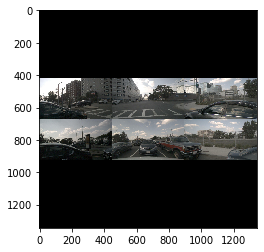

In [ ]:
plt.imshow(  img[0].permute(1, 2, 0)  )

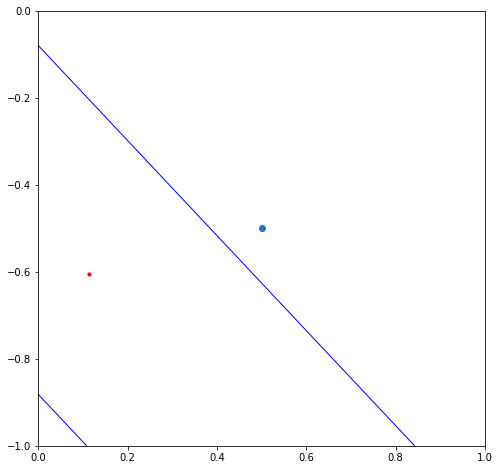

In [ ]:
draw(out[0])

#Testing (Nuscene's Basics)

In [ ]:
classes = nusc.get('category',)

In [ ]:
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
img, label = next(iter(dataloader))
print(img.shape)

torch.Size([2, 3, 1184, 1184])


In [ ]:
loss, out = model(img.to(device),label.to(device))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:217: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:218: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:219: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:220: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/p

In [ ]:
print(non_max_suppression(out.to(device))[1].shape)

torch.Size([8, 11])


In [ ]:
print(out.shape)

torch.Size([2, 86247, 32])


In [ ]:
del imgs,targets,out,loss
torch.cuda.empty_cache()

In [ ]:
print(label[:,2].max())

tensor(0.8393)


In [ ]:
print(label[:,2].max())

tensor(1982.4609)


In [ ]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes 

nusc = NuScenes(version='v1.0-mini', dataroot='drive/My Drive/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.387 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [ ]:
scene = nusc.scene[0]
scene

{'description': 'Parked truck, construction, intersection, turn left, following a van',
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'name': 'scene-0061',
 'nbr_samples': 39,
 'token': 'cc8c0bf57f984915a77078b10eb33198'}

In [ ]:
sample_token = scene['first_sample_token']
sample = nusc.get('sample',sample_token)
sample

{'anns': ['ef63a697930c4b20a6b9791f423351da',
  '6b89da9bf1f84fd6a5fbe1c3b236f809',
  '924ee6ac1fed440a9d9e3720aac635a0',
  '91e3608f55174a319246f361690906ba',
  'cd051723ed9c40f692b9266359f547af',
  '36d52dfedd764b27863375543c965376',
  '70af124fceeb433ea73a79537e4bea9e',
  '63b89fe17f3e41ecbe28337e0e35db8e',
  'e4a3582721c34f528e3367f0bda9485d',
  'fcb2332977ed4203aa4b7e04a538e309',
  'a0cac1c12246451684116067ae2611f6',
  '02248ff567e3497c957c369dc9a1bd5c',
  '9db977e264964c2887db1e37113cddaa',
  'ca9c5dd6cf374aa980fdd81022f016fd',
  '179b8b54ee74425893387ebc09ee133d',
  '5b990ac640bf498ca7fd55eaf85d3e12',
  '16140fbf143d4e26a4a7613cbd3aa0e8',
  '54939f11a73d4398b14aeef500bf0c23',
  '83d881a6b3d94ef3a3bc3b585cc514f8',
  '74986f1604f047b6925d409915265bf7',
  'e86330c5538c4858b8d3ffe874556cc5',
  'a7bd5bb89e27455bbb3dba89a576b6a1',
  'fbd9d8c939b24f0eb6496243a41e8c41',
  '198023a1fb5343a5b6fad033ab8b7057',
  'ffeafb90ecd5429cba23d0be9a5b54ee',
  'cc636a58e27e446cbdd030c14f3718fd',
  '0

In [ ]:
for first_anno in sample['anns'] :
  anno = nusc.get('sample_annotation',first_anno)
  vis = nusc.get('visibility',anno['visibility_token'])
  print(vis)

{'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}
{'description': 'visibility of whole object is between 40 and 60%', 'token': '2', 'level': 'v40-60'}
{'description': 'visibility of whole object is between 60 and 80%', 'token': '3', 'level': 'v60-80'}
{'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
{'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
{'description': 'visibility of whole object is between 0 and 40%', 'token': '1', 'level': 'v0-40'}
{'description': 'visibility of whole object is between 40 and 60%', 'token': '2', 'level': 'v40-60'}
{'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
{'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'level': 'v80-100'}
{'description': 'visibility of whole object is between 80 and 100%', 'token': '4', 'lev

In [ ]:
vis = nusc.get('visibility',anno['visibility_token'])
vis

{'description': 'visibility of whole object is between 0 and 40%',
 'level': 'v0-40',
 'token': '1'}

In [ ]:
import json


with open('/content/drive/My Drive/data/v1.0-mini/category.json') as f:
  data = json.load(f)
for d in data:
  print(d['name'])

human.pedestrian.adult
human.pedestrian.child
human.pedestrian.wheelchair
human.pedestrian.stroller
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.construction_worker
animal
vehicle.car
vehicle.motorcycle
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.truck
vehicle.construction
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.trailer
movable_object.barrier
movable_object.trafficcone
movable_object.pushable_pullable
movable_object.debris
static_object.bicycle_rack


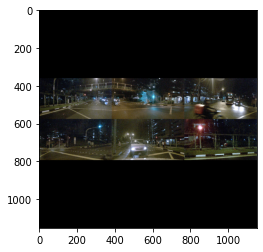

In [ ]:
img,targets = iter(dataloader).next()
plt.imshow(  img[0].permute(1, 2, 0)  )

In [ ]:
output = model(img.to(device))
print(output[...,8].max())

tensor(0.9947)


In [ ]:
output = non_max_suppression(output,conf_thres=0.9)
print(output[0].shape)

torch.Size([10, 11])


In [ ]:
print(targets)

tensor([[0.0000e+00, 0.0000e+00, 4.7458e-01,  ..., 3.2640e-01, 1.1154e-03,
         4.6662e-01],
        [0.0000e+00, 0.0000e+00, 5.0075e-01,  ..., 3.5600e-01, 5.4577e-01,
         9.9790e-01],
        [0.0000e+00, 8.0000e+00, 7.4861e-01,  ..., 3.0260e-01, 3.0156e-01,
         4.1066e-02],
        ...,
        [1.0000e+00, 1.8000e+01, 4.8719e-01,  ..., 2.3620e-01, 3.9791e-01,
         1.0534e-02],
        [1.0000e+00, 1.9000e+01, 7.3987e-01,  ..., 1.5480e-01, 9.9424e-01,
         5.7565e-01],
        [1.0000e+00, 1.9000e+01, 3.6606e-01,  ..., 1.3800e-01, 7.7270e-02,
         7.6702e-01]])


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import clear_output
import time

In [ ]:

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for annotation in targets:
  annotation = nusc.get('sample_annotation',annotation)
  cordinate = [annotation['translation'][i] - ego_pose['translation'][i] for i in range(3)]
  cordinate[0], cordinate[1] = rotate_around_point_lowperf(cordinate[:2], ego_yaw, origin=(0, 0))
  rotation_yaw = quaternion_yaw(annotation['rotation']) - math.pi/2
  print("rotation_yaw = ", quaternion_yaw(annotation['rotation']) + math.pi )
  object_rotation = rotation_yaw - ego_yaw
  height = annotation['size'][0]
  width = annotation['size'][1]
  x_temp, y_temp = rotate_around_point_lowperf((cordinate[0],cordinate[1]),2*math.pi -  (object_rotation+math.pi/2), origin=(cordinate[0]-width/2, cordinate[1] - height/2))
  x_offset, y_offset = x_temp - cordinate[0], y_temp - cordinate[1]
  rectas = patches.Rectangle(xy=((cordinate[0]-width/2) - x_offset, (cordinate[1] - height/2) - y_offset) ,width=width, angle = (object_rotation+math.pi/2)*180/math.pi, height=height, linewidth=1, color='blue', fill=False)
  ax.add_patch(rectas)
  ax.scatter(cordinate[0], cordinate[1], color = 'red', s=10)
  break
ax.scatter(0, 0)
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.show()

In [ ]:
dataset.categories[18]

'movable_object.barrier'

#Angle testing

In [ ]:
#30degree
rotation_yaw = 0
r1 = (1 + math.sin(rotation_yaw))/2
r2 = (1 + math.cos(rotation_yaw))/2
print(r1,r2)
teta1 = math.asin(2*r1 - 1)
teta2 = math.acos(2*r2 - 1)
print(teta1,teta2)
print(angle_decoder([r1,r2])*180/math.pi)

0.5 1.0
0.0 0.0
0.0


In [ ]:
#120degree
rotation_yaw = math.pi/2 
r1 = (1 + math.sin(rotation_yaw))/2
r2 = (1 + math.cos(rotation_yaw))/2
print(r1,r2)
teta1 = math.asin(2*r1 - 1)
teta2 = math.acos(2*r2 - 1)
print(teta1,teta2)
print(angle_decoder([r1,r2])*180/math.pi)

1.0 0.5
1.5707963267948966 1.5707963267948966
90.0


In [ ]:
#210degree
rotation_yaw = math.pi
r1 = (1 + math.sin(rotation_yaw))/2
r2 = (1 + math.cos(rotation_yaw))/2
print(r1,r2)
teta1 = math.asin(2*r1 - 1)
teta2 = math.acos(2*r2 - 1)
print(teta1,teta2)
print(angle_decoder([r1,r2])*180/math.pi)

0.5000000000000001 0.0
2.220446049250313e-16 3.141592653589793
180.0


In [ ]:
#300degree
rotation_yaw = 3*math.pi/2
r1 = (1 + math.sin(rotation_yaw))/2
r2 = (1 + math.cos(rotation_yaw))/2
print(r1,r2)
teta1 = math.asin(2*r1 - 1)
teta2 = math.acos(2*r2 - 1)
print(teta1,teta2)
print(angle_decoder([r1,r2])*180/math.pi)

0.0 0.4999999999999999
-1.5707963267948966 1.5707963267948968
270.0


#Intersection Area Testing

In [ ]:
from turfpy.transformation import intersect
from turfpy.measurement import area
from geojson import Feature
f = Feature(geometry={"coordinates": [
[[-122.801742, 45.48565], [-122.801742, 45.60491],
[-122.584762, 45.60491], [-122.584762, 45.48565],
[-122.801742, 45.48565]]], "type": "Polygon"})
b = Feature(geometry={"coordinates": [
[[-122.520217, 45.535693], [-122.64038, 45.553967],
[-122.720031, 45.526554], [-122.669906, 45.507309],
[-122.723464, 45.446643], [-122.532577, 45.408574],
[-122.487258, 45.477466], [-122.520217, 45.535693]
]], "type": "Polygon"})
inter = intersect([f, b])
area(inter)

56901155.05995309

In [ ]:
!pip install turfpy

  Created wheel for turfpy: filename=turfpy-0.0.4-cp36-none-any.whl size=32317 sha256=76b9dc9f683d5b6eae6f404c1b15fd5ee26c92a78086a865e43952be574641aa
  Stored in directory: /root/.cache/pip/wheels/e8/5a/1f/216423b705f113c02e3c287b8c5ce31df9a8c6a5526c4da56c
Successfully built turfpy
